In [1]:
import scanpy as sc
import scvelo as scv
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 4000 highly variable genes.
Logarithmized X.
computing neighbors


/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


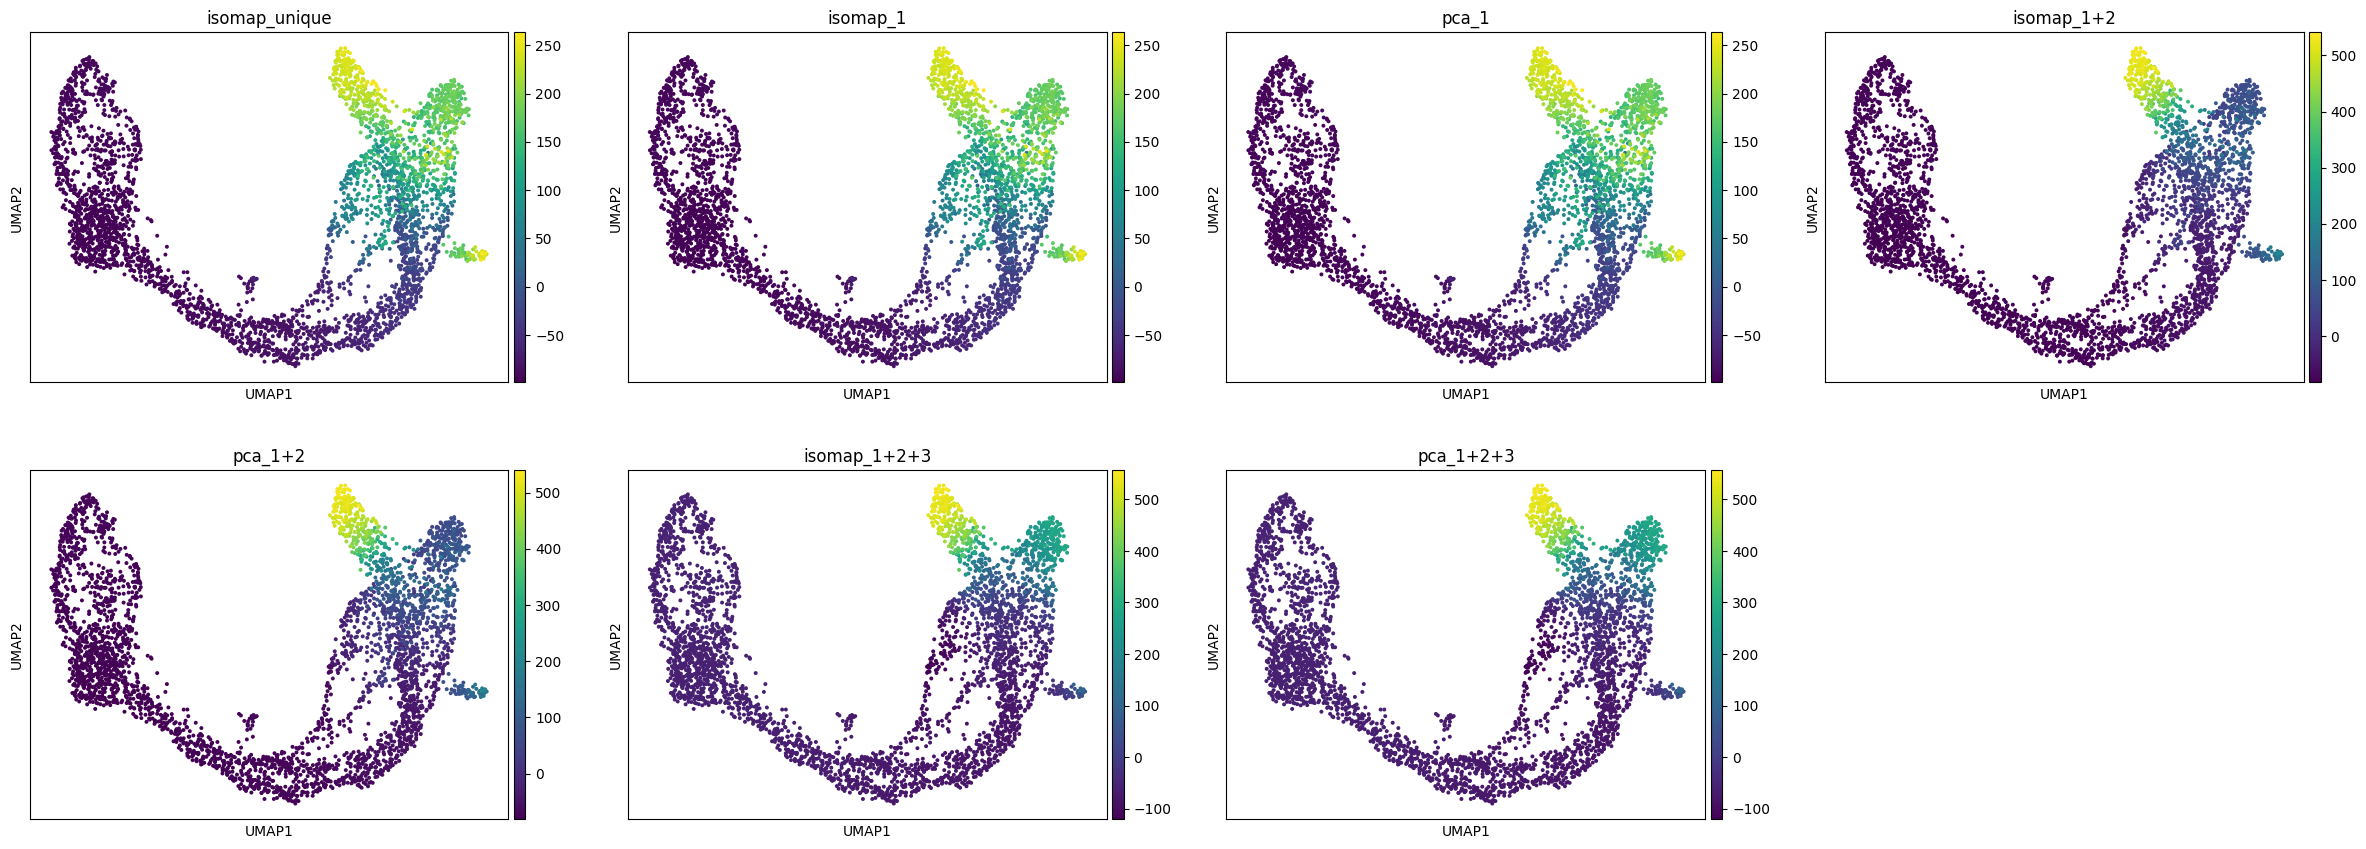

In [31]:
dataset_name = "pancreas"
cell_type_key = "clusters"
n_highly_var_genes = 4000
n_components = 3
n_neighbors_isomap = 3695
n_smooth = 200

if dataset_name == "pancreas":
    adata = scv.datasets.pancreas()
elif dataset_name == "gastrulation_erythroid":
    adata = scv.datasets.gastrulation_erythroid()
    #adata = adata[adata.obs["stage"]=="E8.25"].copy()
elif dataset_name == "forebrain":
    adata = scv.datasets.forebrain()
elif dataset_name == "dentategyrus_lamanno":
    adata = scv.datasets.dentategyrus_lamanno()
elif dataset_name == "dentategyrus_lamanno_P0":
    adata = scv.datasets.dentategyrus_lamanno()
    adata = adata[adata.obs["Age"] == "P0"].copy()
elif dataset_name == "dentategyrus_lamanno_P5":
    adata = scv.datasets.dentategyrus_lamanno()
    adata = adata[adata.obs["Age"] == "P5"].copy()

adata.obs[cell_type_key] = [str(cat) for cat in list(adata.obs[cell_type_key])]
adata.obs[cell_type_key] = pd.Series(adata.obs[cell_type_key], dtype="category")
unique_categories = adata.obs[cell_type_key].cat.categories
rgb_colors = sns.color_palette("tab20", len(unique_categories))
hex_colors = ['#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255)) for r, g, b in rgb_colors]
adata.uns[f"{cell_type_key}_colors"] = hex_colors

adata.layers['counts_unspliced'] = adata.layers["unspliced"].copy()
adata.layers['counts_spliced'] = adata.layers["spliced"].copy()

scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=n_highly_var_genes) #filter and normalize
scv.pp.moments(adata, n_neighbors=n_smooth)
MuMs = np.concatenate([adata.layers["Mu"], adata.layers["Ms"]], axis=1)
#MuMs = adata.layers["Ms"]
adata.obsm["MuMs"] = MuMs
isomap = Isomap(n_components=n_components, n_neighbors=n_neighbors_isomap).fit_transform(MuMs)
isomap_unique = Isomap(n_components=1, n_neighbors=n_neighbors_isomap).fit_transform(MuMs)
adata.obs["isomap_unique"] = isomap_unique
pca = PCA(n_components=n_components).fit_transform(MuMs)

adata.obsm["isomap"] = isomap
adata.obsm["pca"] = pca
adata.obs["isomap_1"] = isomap[:,0]
adata.obs["isomap_2"] = isomap[:,1]
adata.obs["isomap_3"] = isomap[:,2]
adata.obs["pca_1"] = pca[:,0]
adata.obs["pca_2"] = pca[:,1]
adata.obs["pca_3"] = pca[:,2]
adata.obs["isomap_1+2"] = isomap[:,0] + isomap[:,1] 
adata.obs["pca_1+2"] = pca[:,0] + pca[:,1]
adata.obs["isomap_1+2+3"] = isomap[:,0] + isomap[:,1] + isomap[:,2]
adata.obs["pca_1+2+3"] = pca[:,0] + pca[:,1] + pca[:,2]
time_key = "isomap_unique"

if dataset_name.startswith("dentategyrus"):
    adata.obsm["X_umap"] = adata.obsm["X_tsne"]
if dataset_name == "forebrain":
    sc.tl.umap(adata)
sc.pl.umap(adata, color=["isomap_unique", "isomap_1", "pca_1", "isomap_1+2", "pca_1+2", "isomap_1+2+3", "pca_1+2+3"])

In [26]:
time_key = "isomap_unique"


In [27]:
def least_squares_slope(time_vector, quantity_vector):
    """
    Computes the slope of the least squares line for the given time and quantity vectors.
    
    Parameters:
    time_vector (numpy.ndarray): The input time vector.
    quantity_vector (numpy.ndarray): The input quantity vector.
    
    Returns:
    float: The slope of the least squares line.
    """
    n = len(time_vector)
    sum_x = np.sum(time_vector)
    sum_y = np.sum(quantity_vector)
    sum_xy = np.sum(time_vector * quantity_vector)
    sum_x_squared = np.sum(time_vector ** 2)
    
    numerator = n * sum_xy - sum_x * sum_y
    denominator = n * sum_x_squared - sum_x ** 2
    
    if denominator == 0:
        raise ValueError("Denominator is zero, cannot compute slope.")
    
    slope = numerator / denominator
    return slope

In [17]:
"""root_idx = 915
array = np.absolute(adata.obs["isomap_1"] - adata.obs["isomap_1"][root_idx])
min_val = np.min(array)
max_val = np.max(array)

# Apply the min-max scaling formula
array = (array - min_val) / (max_val - min_val)
adata.obs["scaled_isomap_1"] = array
sc.pl.umap(adata, color="scaled_isomap_1")"""

'root_idx = 915\narray = np.absolute(adata.obs["isomap_1"] - adata.obs["isomap_1"][root_idx])\nmin_val = np.min(array)\nmax_val = np.max(array)\n\n# Apply the min-max scaling formula\narray = (array - min_val) / (max_val - min_val)\nadata.obs["scaled_isomap_1"] = array\nsc.pl.umap(adata, color="scaled_isomap_1")'

In [32]:
import pandas as pd
adata.layers["velocity_u"] = np.zeros(adata.shape)
adata.layers["velocity"] = np.zeros(adata.shape)
for ctype in pd.unique(adata.obs[cell_type_key]):
    print(f"computing slopes for ctype: {ctype}..")
    ctype_obs = np.where(adata.obs[cell_type_key] == ctype)[0]
    for i,gene in enumerate(list(adata.var_names)):
        Mu = adata.layers["Mu"]
        Ms = adata.layers["Ms"]
        quantity_vector_u = Mu[ctype_obs,i]
        quantity_vector_s = Ms[ctype_obs,i]
        time_vector = adata.obs[time_key][ctype_obs]
        velocity_u = least_squares_slope(time_vector, quantity_vector_u)
        velocity = least_squares_slope(time_vector, quantity_vector_s)
        adata.layers["velocity_u"][ctype_obs, i] = velocity_u
        adata.layers["velocity"][ctype_obs, i] = velocity

        if f"slope_{gene}_u" not in adata.obs:
            adata.obs[f"slope_{gene}_u"] = 0
        if f"slope_{gene}_s" not in adata.obs:
            adata.obs[f"slope_{gene}_s"] = 0

        adata.obs[f"slope_{gene}_u"][ctype_obs] = velocity_u
        adata.obs[f"slope_{gene}_s"][ctype_obs] = velocity

computing slopes for ctype: Pre-endocrine..
computing slopes for ctype: Ductal..
computing slopes for ctype: Alpha..
computing slopes for ctype: Ngn3 high EP..
computing slopes for ctype: Delta..
computing slopes for ctype: Beta..
computing slopes for ctype: Ngn3 low EP..
computing slopes for ctype: Epsilon..


computing velocity graph (using 1/24 cores)
    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
computing terminal states
    identified 7 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs

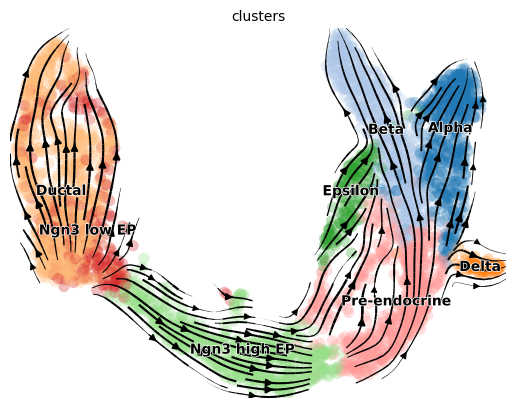

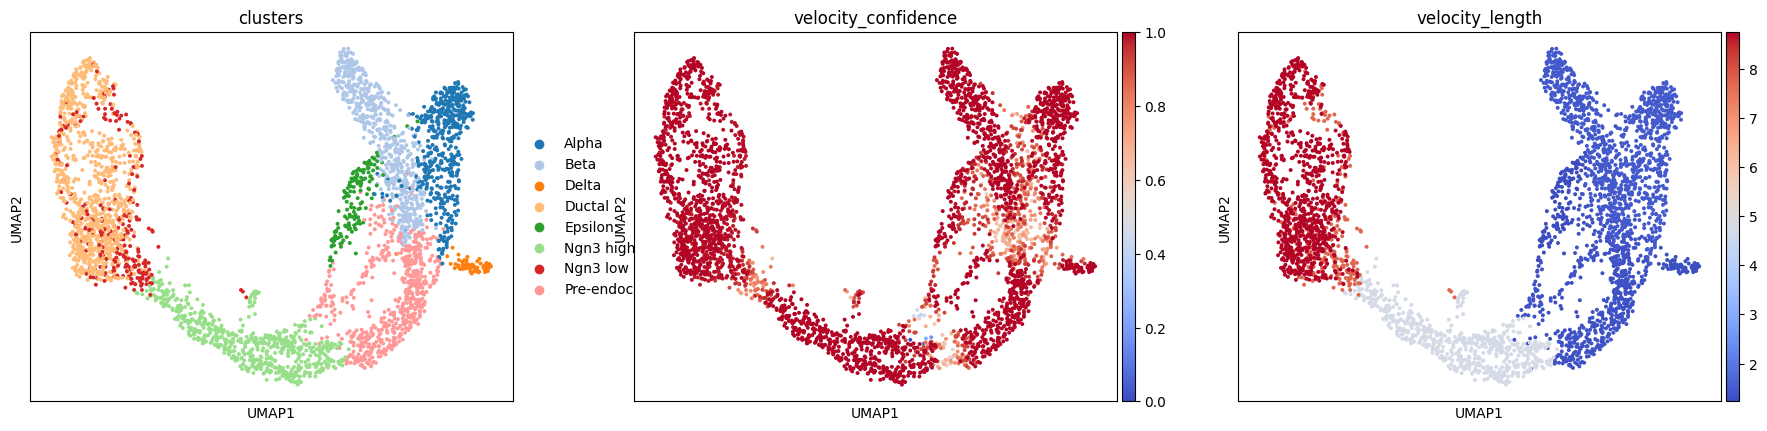

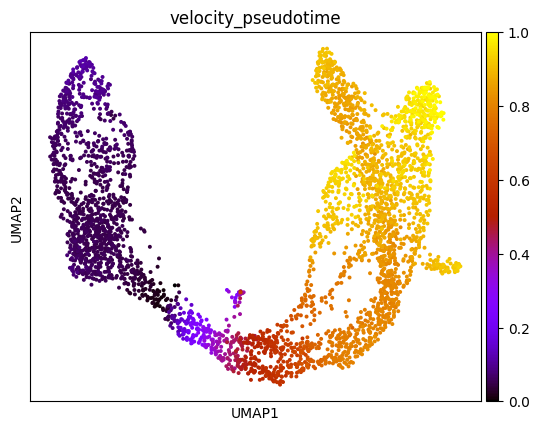

In [33]:
sc.pp.neighbors(adata)
#adata.layers["velocity"] *= -1
scv.tl.velocity_graph(adata, vkey="velocity")
scv.tl.velocity_confidence(adata, vkey="velocity")
scv.tl.velocity_pseudotime(adata, vkey="velocity")
scv.pl.velocity_embedding_stream(adata, color=cell_type_key, vkey="velocity")
keys = [cell_type_key,"velocity_confidence", "velocity_length"]
sc.pl.umap(adata, color=keys, color_map="coolwarm")
sc.pl.umap(adata, color="velocity_pseudotime", color_map="gnuplot")

In [20]:
import matplotlib.pyplot as plt
def plot_phase_plane(adata, gene_name, dataset, K, u_scale=.01, s_scale=0.01, alpha=0.5, head_width=0.02, head_length=0.03, length_includes_head=False, log=False,
                        norm_velocity=True, filter_cells=False, smooth_expr=True, show_plot=True, save_plot=True, save_path=".",
                        cell_type_key="clusters", vkey="velocity", vkey_u="velocity_u"):

    if smooth_expr:
        unspliced_expression = adata.layers["Mu"][:, adata.var_names.get_loc(gene_name)].flatten() 
        spliced_expression = adata.layers["Ms"][:, adata.var_names.get_loc(gene_name)].flatten() 
    else:
        unspliced_expression = adata.layers["unspliced"][:, adata.var_names.get_loc(gene_name)].flatten()
        spliced_expression = adata.layers["spliced"][:, adata.var_names.get_loc(gene_name)].flatten()

    # Normalize the expression data
    unspliced_expression_min, unspliced_expression_max = np.min(unspliced_expression), np.max(unspliced_expression)
    spliced_expression_min, spliced_expression_max = np.min(spliced_expression), np.max(spliced_expression)

    # Min-Max normalization
    unspliced_expression = (unspliced_expression - unspliced_expression_min) / (unspliced_expression_max - unspliced_expression_min)
    spliced_expression = (spliced_expression - spliced_expression_min) / (spliced_expression_max - spliced_expression_min)

    # Extract the velocity data
    unspliced_velocity = adata.layers[f'{vkey_u}'][:, adata.var_names.get_loc(gene_name)].flatten()
    spliced_velocity = adata.layers[f'{vkey}'][:, adata.var_names.get_loc(gene_name)].flatten()

    def custom_scale(data):
        max_abs_value = np.max(np.abs(data))  # Find the maximum absolute value
        scaled_data = data / max_abs_value  # Scale by the maximum absolute value
        return scaled_data

    if norm_velocity:
        unspliced_velocity = custom_scale(unspliced_velocity)
        spliced_velocity = custom_scale(spliced_velocity)


    # Apply any desired transformations (e.g., log) here
    if log:
        # Apply log transformation safely, ensuring no log(0)
        unspliced_velocity = np.log1p(unspliced_velocity)
        spliced_velocity = np.log1p(spliced_velocity)

    # Generate boolean masks for conditions and apply them
    if filter_cells:
        valid_idx = (unspliced_expression > 0) & (spliced_expression > 0)
    else:
        valid_idx = (unspliced_expression >= 0) & (spliced_expression >= 0)

    # Filter data based on valid_idx
    unspliced_expression_filtered = unspliced_expression[valid_idx]
    spliced_expression_filtered = spliced_expression[valid_idx]
    unspliced_velocity_filtered = unspliced_velocity[valid_idx]
    spliced_velocity_filtered = spliced_velocity[valid_idx]

    # Also filter cell type information to match the filtered expressions
    # First, get unique cell types and their corresponding colors
    unique_cell_types = adata.obs[cell_type_key].cat.categories
    celltype_colors = adata.uns[f"{cell_type_key}_colors"]
    
    # Create a mapping of cell type to its color
    celltype_to_color = dict(zip(unique_cell_types, celltype_colors))

    # Filter cell types from the data to get a list of colors for the filtered data points
    cell_types_filtered = adata.obs[cell_type_key][valid_idx]
    colors = cell_types_filtered.map(celltype_to_color).to_numpy()
    plt.figure(figsize=(9, 6.5), dpi=100)
  # Lower dpi here if the file is still too large    scatter = plt.scatter(unspliced_expression_filtered, spliced_expression_filtered, c=colors, alpha=0.6)

    """# Plot velocity vectors
    for i in range(len(unspliced_expression_filtered)):
        cell_type_index = np.where(unique_cell_types == cell_types_filtered[i])[0][0]
        arrow_color = celltype_to_color[cell_types_filtered[i]]  # Use the color corresponding to the cell type
        plt.arrow(
            unspliced_expression_filtered[i], spliced_expression_filtered[i], 
            unspliced_velocity_filtered[i] * u_scale, spliced_velocity_filtered[i] * s_scale, 
            color=arrow_color, alpha=alpha, head_width=head_width, head_length=head_length, length_includes_head=length_includes_head
        )"""

    # Plot velocity vectors
    for i in range(len(unspliced_expression_filtered)):
        cell_type_index = np.where(unique_cell_types == cell_types_filtered[i])[0][0]
        arrow_color = celltype_to_color[cell_types_filtered[i]]  # Use the color corresponding to the cell type
        plt.arrow(
            spliced_expression_filtered[i], unspliced_expression_filtered[i], 
            spliced_velocity_filtered[i] * s_scale, unspliced_velocity_filtered[i] * u_scale, 
            color=arrow_color, alpha=alpha, head_width=head_width, head_length=head_length, length_includes_head=length_includes_head
        )

    plt.ylabel(f'Normalized Unspliced Expression of {gene_name}')
    plt.xlabel(f'Normalized Spliced Expression of {gene_name}')
    plt.title(f'Expression and Velocity of {gene_name} by Cell Type')

    # Create a legend
    patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=celltype_to_color[celltype], markersize=10, label=celltype) 
            for celltype in unique_cell_types]
    plt.legend(handles=patches, title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')

    
    plt.show()

In [21]:
adata.var_names

Index(['Sntg1', 'Snhg6', 'Arfgef1', 'Ncoa2', 'Lactb2', 'Sbspon', 'Stau2',
       'Ube2w', 'Mcm3', 'Fam135a',
       ...
       'Rai2', 'Rbbp7', 'Ctps2', 'Ap1s2', 'Tmem27', 'Gpm6b', 'Uty', 'Ddx3y',
       'Eif2s3y', 'Erdr1'],
      dtype='object', name='index', length=4000)

In [22]:
scv.tl.rank_velocity_genes(adata, groupby=cell_type_key)

ranking velocity genes


/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scvelo/tools/utils.py:463: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:05) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


In [23]:
df = pd.DataFrame(adata.uns["rank_velocity_genes"]["names"])
df

,Alpha,Beta,Delta,Ductal,Epsilon,Ngn3 high EP,Ngn3 low EP,Pre-endocrine
0,Gcg,Ins2,Chrm3,Cpa2,Ndst4,Fxyd3,Eya2,Ghr
1,Heg1,Vps8,Ptprz1,Kcnq1,Syt9,Plppr2,Snrk,Scgn
2,Tgfb2,Arhgap36,Unc5c,Daam1,Pou6f2,Syt11,Tpst2,Fam35a
3,Ttc39b,Nnat,Ptprt,Hpgd,Pde1a,Klc2,Cpt2,Snx4
4,Slc7a2,Sytl4,Sorcs1,Proser2,Tnr,Syn2,Trim62,Ap1s2
...,...,...,...,...,...,...,...,...
95,Ppp1r9a,Rpl32,Dusp5,Cenpf,Tnik,Tbl1xr1,Ccnjl,Acat1
96,Grhpr,Ptprz1,Erap1,Amz2,Kif21a,Ddit3,Cep97,Pyy
97,Mospd1,Ociad2,Fam134b,Ndc80,Fam213a,Slit1,Cdc25c,Gopc
98,Sobp,D930015E06Rik,Acadsb,Cntrl,Arhgap32,Vat1l,Pik3r3,Filip1


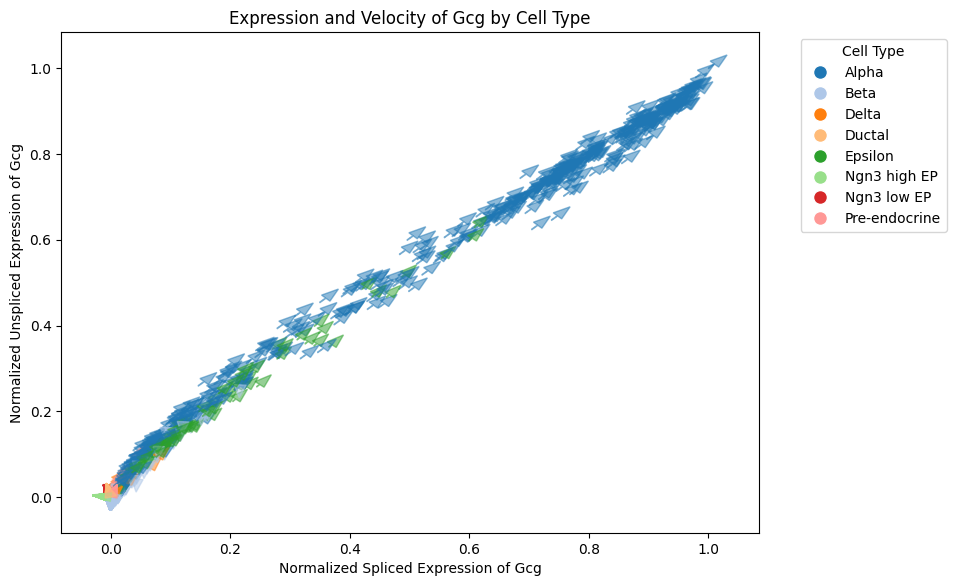

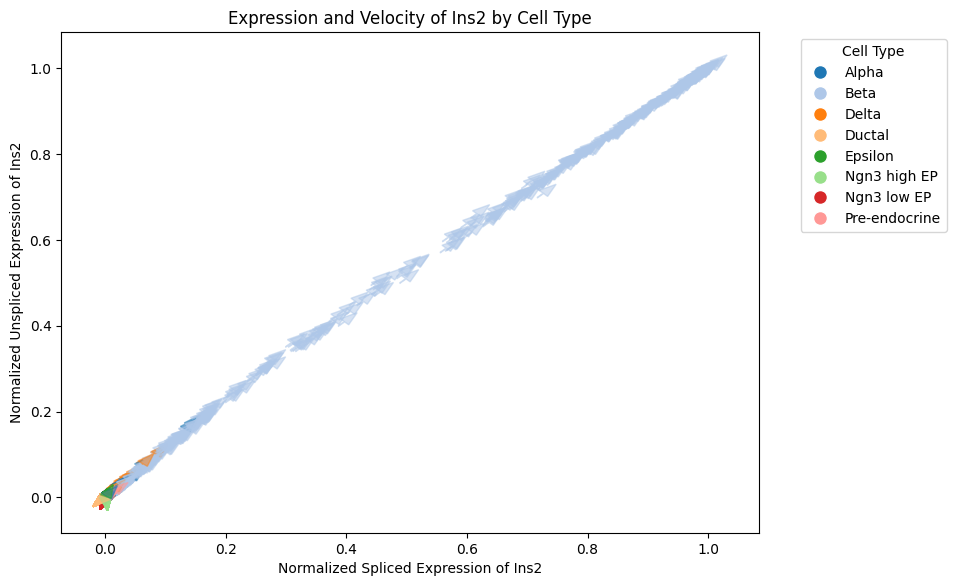

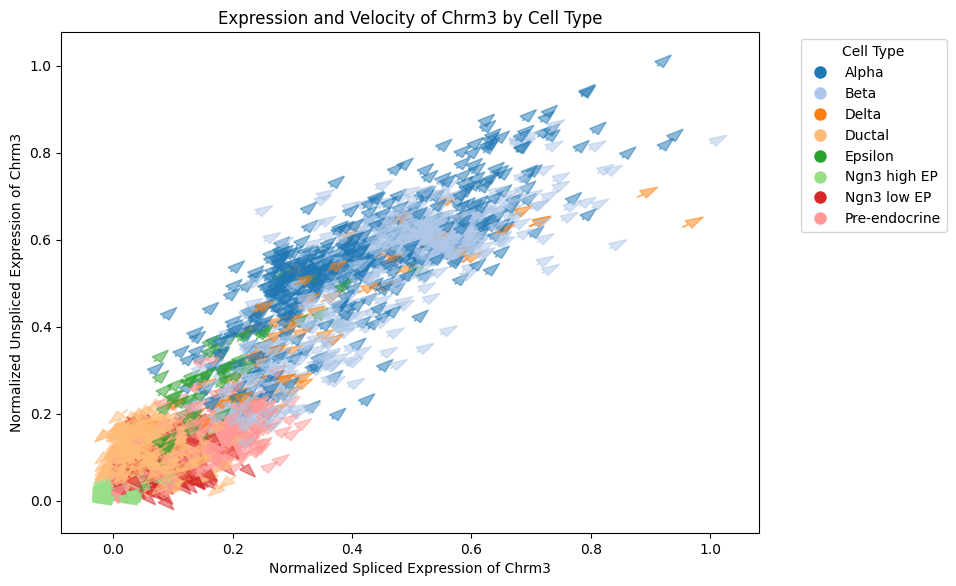

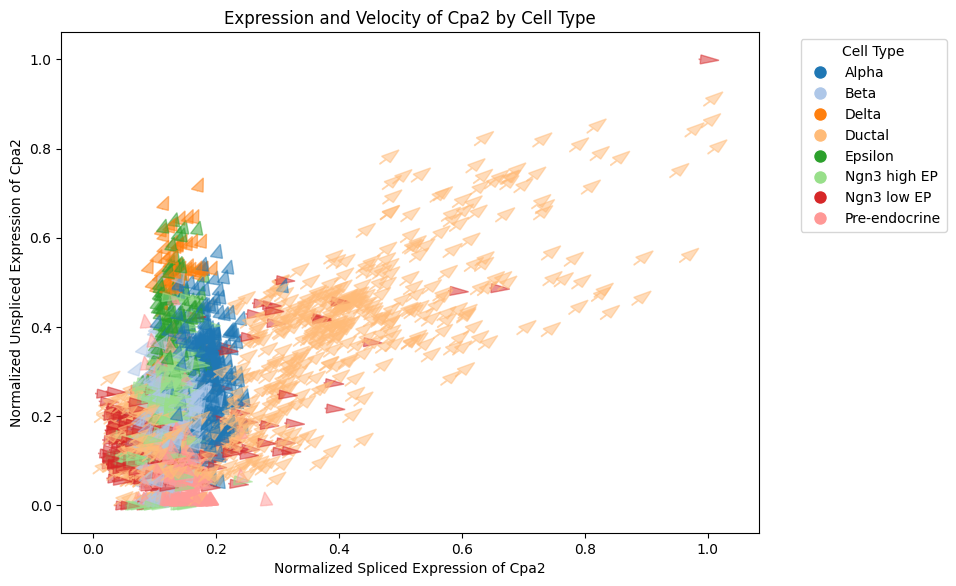

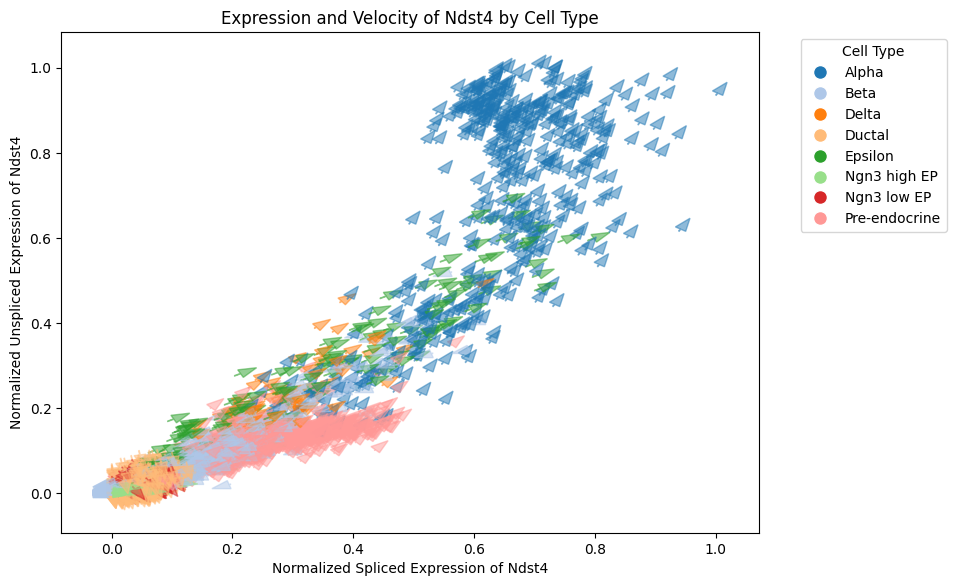

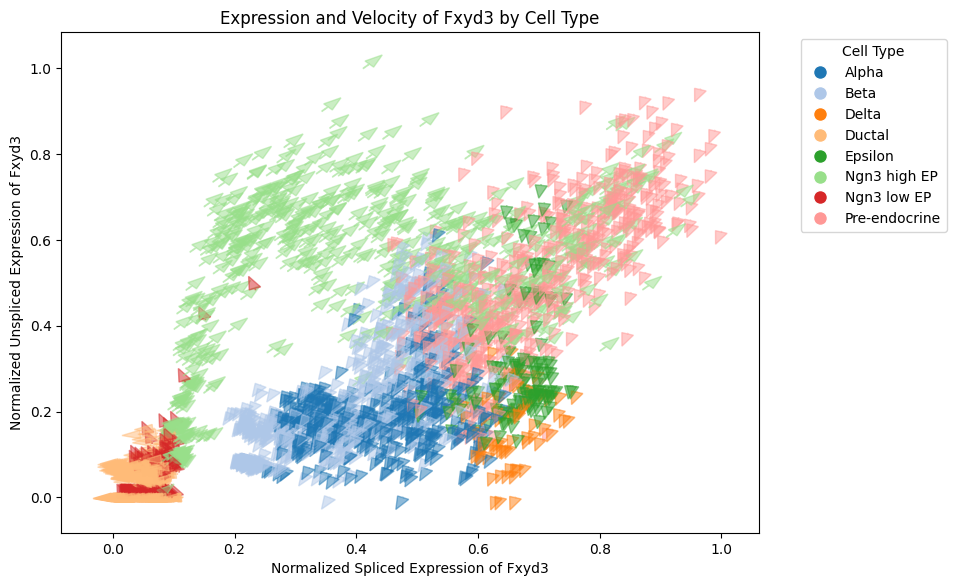

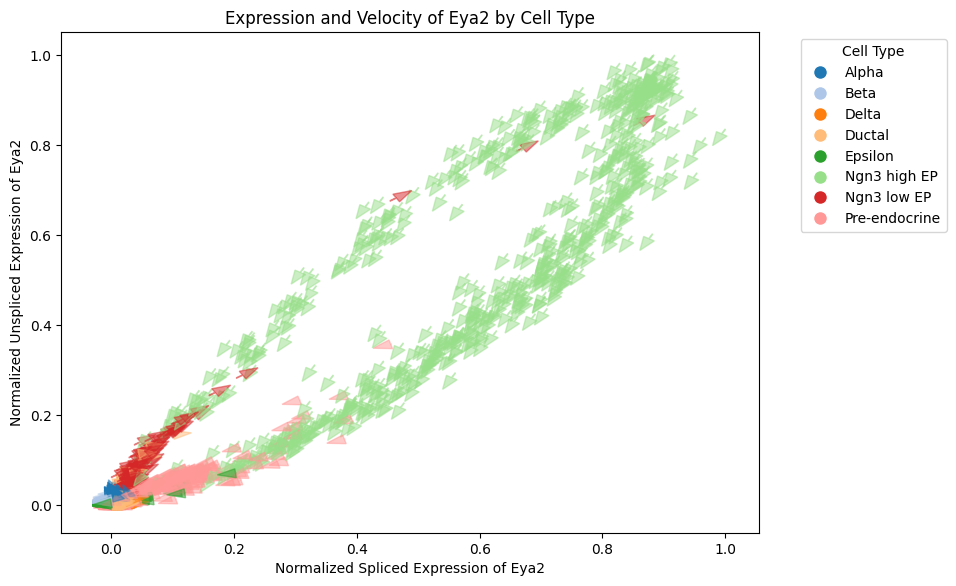

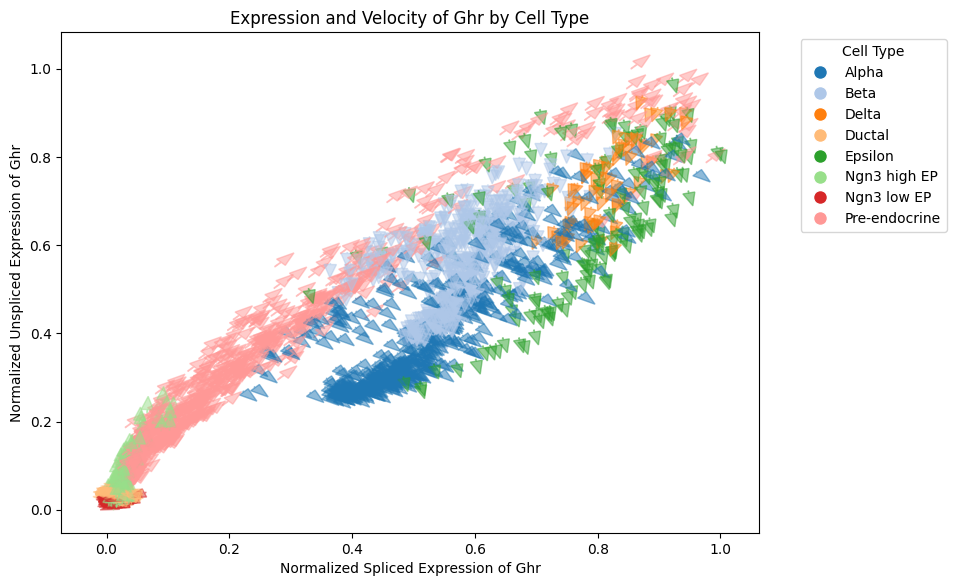

In [34]:
for gene in df.iloc[0]:
    plot_phase_plane(adata, gene, "pancreas", u_scale=.01, s_scale=.01, K=10, cell_type_key=cell_type_key, vkey="velocity", vkey_u="velocity_u")


In [35]:
velocity_u_s = np.concatenate([adata.layers["velocity_u"], adata.layers["velocity"]], axis=1)
np.save("../../inputs/baseline_velocity_200_neighbors_pancreas.npy", velocity_u_s)